#### Modeling Phase 

The Modeling notebook is broken into the following parts
- Feature Selection 
- Models 
- Results

In [263]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import shap

In [296]:
df = pd.read_csv('data/QQQ_modified_data.csv', ).rename(columns={'Unnamed: 0': 'Date'}).drop(columns=['Close'])

In [297]:
# remove the first 30 rows of data to eliminate NaN values
df = df.iloc[30:]

In [298]:
df_with_dummies = df[['cross', 'triple cross']]
df_with_dummies = pd.get_dummies(df_with_dummies).astype(int)

df = pd.concat([df, df_with_dummies], axis=1)

df = df.drop(['cross', 'triple cross'], axis=1)

In [325]:
X = df.drop(columns=['Date', 'Future1M_movement_direction', 'Future2M_movement_direction', 'Future15d_movement_direction'])

targets = df[['Future1M_movement_direction', 'Future2M_movement_direction', 'Future15d_movement_direction']].replace(-1, 0)

y1M = targets['Future1M_movement_direction'].values
y2M = targets['Future2M_movement_direction'].values
y15D = targets['Future15d_movement_direction'].values

#### Feature Selection 
- LASSO: a linear regression technique that penalizes the absolute size of the regression coefficients, effectively encouraging sparse solutions where some coefficients are exactly zero. It is commonly used for feature selection by shrinking less important features' coefficients to zero, thereby identifying the most relevant features for prediction.
- RFE (XGBoost): feature selection technique that iteratively removes less important features based on their importance scores obtained from XGBoost. By leveraging the power of XGBoost's gradient boosting algorithm, XGBoost RFE identifies a subset of the most relevant features, improving model interpretability and potentially enhancing predictive performance.

In [310]:
# LASSO util function

def lasso_feature_selection(X, y, model_type):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lasso = Lasso(alpha=0.1)  
    lasso.fit(X_scaled, y)
    
    feature_coefficients = pd.Series(lasso.coef_, index=X.columns) 

    sorted_coefficients = feature_coefficients.abs().sort_values(ascending=False)
    
    top_10_features = sorted_coefficients.head(10)
    
    results_df = pd.DataFrame({
        'Feature': top_10_features.index,  
        'Coefficient': top_10_features.values,
        'Model_Type': model_type
    })
    
    return results_df

In [311]:
# XGBOOST util function

def feature_importance(X, y, model_type):
    xgb = XGBClassifier()
    xgb.fit(X, y1M)
    
    # Get feature importance values for selected features
    feature_importance_values = pd.Series(xgb.feature_importances_, index=X.columns, name='Coefficient').sort_values(ascending=False)

    feature_importance_values = feature_importance_values.to_frame().reset_index().rename(columns={'index': 'Feature', 'Coefficient': 'Coefficient', 'Model_Type': model_type})

    return feature_importance_values

In [312]:
# Run function - LASSO 
y1M_lasso_results = lasso_feature_selection(X=X, y=y1M, model_type='Lasso Regression')
y2M_lasso_results = lasso_feature_selection(X=X, y=y2M, model_type='Lasso Regression')
y15D_lasso_results = lasso_feature_selection(X=X, y=y15D, model_type='Lasso Regression')

In [313]:
# Run function - rfe
y1M_rfe_results = xgboost_rfe_feature_selection(X=X, y=y1M, model_type = 'XGBoost RFE', n_features_to_select=10)
y2M_rfe_results = xgboost_rfe_feature_selection(X=X, y=y2M, model_type = 'XGBoost RFE', n_features_to_select=10)
y15D_rfe_results = xgboost_rfe_feature_selection(X=X, y=y15D, model_type = 'XGBoost RFE', n_features_to_select=10)

In [314]:
# connect together results for each respective target
y1M_results = pd.concat([y1M_lasso_results, y1M_rfe_results]).sort_values(by='Coefficient', ascending=False)
y2M_results = pd.concat([y2M_lasso_results, y2M_rfe_results]).sort_values(by='Coefficient', ascending=False)
y15D_results = pd.concat([y15D_lasso_results, y15D_rfe_results]).sort_values(by='Coefficient', ascending=False)

In [337]:
# select top 10 features and filter the X dataframe to only include those features and convert to numpy array
inputs_1M = X[y1M_results['Feature'].head(10)].values
inputs_2M = X[y2M_results['Feature'].head(10)].values
inputs_15D = X[y15D_results['Feature'].head(10)].values

#### Models

Types of Linear and non-linear models 
- Logistic Regression
- Decision Trees
- XGBoost

Cross-validation Approach: TimeSeries Cross-Validation with 5 folds is a technique used for evaluating time series models, where the data is divided into five consecutive and non-overlapping folds. Each fold acts as a test set once while the preceding data is used for training. This approach helps assess model performance while preserving the temporal order of the data


All models will be evaluated with the following metrics 
- Precision: Proportion of correctly classified instances (both true positives and true negatives) out of the total number of instances
- Accuracy Metric: Proportion of true positive predictions among all positive predictions made by the model
- Recall (True Positive Rate): Proportion of true positive predictions among all actual positive instances in the dataset


In [317]:
# Instantiate the models
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
xgboost = XGBClassifier()

In [425]:
# util function 

def evaluate_model_with_cross_validation(X, y, model, model_name, n_splits=5):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = []

    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val = X_train[train_index], X_train[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        
        # Train model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict
        y_pred = model.predict(X_val)
        
        # Evaluate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        
        metrics.append({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})

    # Calculate average metrics
    average_metrics = {k: np.mean([metric[k] for metric in metrics]) for k in metrics[0]}

    # Fit model to entire training set to get feature importance or coefficients
    model.fit(X_train, y_train)
    
    # Evaluate model on the independent test set
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Create DataFrame with metrics, feature importance, and coefficients
    df = pd.DataFrame({
        'Model': [model_name],
        'Average_Accuracy': [average_metrics['Accuracy']],
        'Average_Precision': [average_metrics['Precision']],
        'Average_Recall': [average_metrics['Recall']],
        'Test_Accuracy': [test_accuracy]
    })

    return df, model, X_val

## Results 

In [ ]:
logistic_1M_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_1M, y=y1M, model=logistic_regression, model_name='Logistic Regression')
decision_tree_1M_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_1M, y=y1M, model=decision_tree, model_name='Decision Tree')
xgboost_1M_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_1M, y=y1M, model=xgboost, model_name='XGBoost')

results_df_1M = pd.concat([logistic_1M_df, decision_tree_1M_df, xgboost_1M_df])

logistic_2M_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_2M, y=y2M, model=logistic_regression, model_name='Logistic Regression')
decision_tree_2M_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_2M, y=y2M, model=decision_tree, model_name='Decision Tree')
xgboost_2M_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_2M, y=y2M, model=xgboost, model_name='XGBoost')

results_df_2M = pd.concat([logistic_2M_df, decision_tree_2M_df, xgboost_2M_df])

logistic_15D_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_15D, y=y15D, model=logistic_regression, model_name='Logistic Regression')
decision_tree_15D_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_15D, y=y15D, model=decision_tree, model_name='Decision Tree')
xgboost_15D_df, model, X_val = evaluate_model_with_cross_validation(X=inputs_15D, y=y15D, model=xgboost, model_name='XGBoost')

results_df_15D = pd.concat([logistic_15D_df, decision_tree_15D_df, xgboost_15D_df])

In [427]:
results_df_1M

,Model,Average_Accuracy,Average_Precision,Average_Recall,Test_Accuracy
0,Logistic Regression,0.558249,0.746732,0.671745,0.498881
0,Decision Tree,0.536027,0.682879,0.526474,0.664430
0,XGBoost,0.606061,0.754591,0.747030,0.604027


In [428]:
results_df_2M

,Model,Average_Accuracy,Average_Precision,Average_Recall,Test_Accuracy
0,Logistic Regression,0.541414,0.772363,0.687822,0.440716
0,Decision Tree,0.643098,0.805485,0.768418,0.689038
0,XGBoost,0.554882,0.839831,0.662456,0.668904


In [429]:
results_df_15D

,Model,Average_Accuracy,Average_Precision,Average_Recall,Test_Accuracy
0,Logistic Regression,0.538721,0.738891,0.635062,0.588367
0,Decision Tree,0.560943,0.749220,0.580949,0.474273
0,XGBoost,0.595960,0.744511,0.690468,0.501119


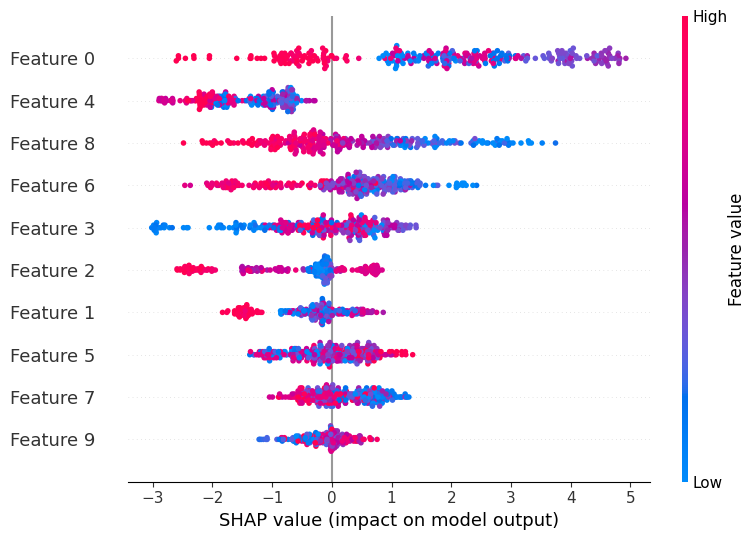

In [431]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)